# Extracting Vertices and Image number of a line from JSON file

In [138]:
# !pip install opencv-python
# !pip install bezier
# !pip install matplotlib
# !pip install sklearn
# !pip install pypng

In [51]:
import json
import cv2
import glob
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import spline
import bezier
import os
import png
%matplotlib inline

In [5]:
'''
Do it at the end!
'''
def parsingJSON(filename):
    return segmentation_mask

In [140]:
json_data=open('/home/maharshi.t25/bdd100k_labels_images_train.json').read()

data_train = json.loads(json_data)

In [ ]:
data_train

In [2]:
'''

How to parse a JSON data file?

1) data_train[0] - The first image
2) data_train[0] has the length 4; 1st element in the dictionary is the name, 2nd element in the dictionary is attributes,
3rd element of the dictionary is timestamp and the 4th element is the labels
3) data_train[0]['labels']- gives the list of all the present categories in the image
4) data_train[0]['labels'][0]- gives the dictionary of the first category in the image
5) data_train[0]['labels'][0]['category']- returns the name of the category present in the image
'''
data_train[0]['labels'][10]
# for i,j in enumerate(data_train):
    

"\n\nHow to parse a JSON data file?\n\n1) data_train[0] - The first image\n2) data_train[0] has the length 4; 1st element in the dictionary is the name, 2nd element in the dictionary is attributes,\n3rd element of the dictionary is timestamp and the 4th element is the labels\n3) data_train[0]['labels']- gives the list of all the present categories in the image\n4) data_train[0]['labels'][0]- gives the dictionary of the first category in the image\n5) data_train[0]['labels'][0]['category']- returns the name of the category present in the image\n"

In [175]:
# Parsing the JSON file for vertices
det_train=dict()
points=[]
for i,j in enumerate(data_train):
    points=[]    
    for k,l in enumerate(data_train[i]['labels']):
        if data_train[i]['labels'][k]['category'] == 'lane':
            points.append(data_train[i]['labels'][k]['poly2d'][0]['vertices'])
    det_train[j['name']]=points

det_train

{'0000f77c-6257be58.jpg': [[[503.674413, 373.137193],
   [357.797732, 374.672737]],
  [[62.973282, 371.601649], [0, 368.53056]],
  [[1274.517503, 376.208281], [905.986941, 371.601649]]],
 '0000f77c-62c2a288.jpg': [[[1230.99113, 620.749416],
   [1097.642939, 531.482176],
   [826.538354, 414.663319],
   [829.844506, 367.274536]],
  [[889.355269, 332.008466],
   [601.719915, 348.539436],
   [299.757899, 400.336477],
   [23.143057, 447.725259]],
  [[28.653314, 451.031454],
   [251.267647, 411.357124],
   [460.657368, 377.193118],
   [674.455293, 352.947695]],
  [[722.945545, 351.84563],
   [482.698391, 380.499314],
   [241.347048, 456.245103],
   [0, 510.542947]],
  [[1143.929088, 604.218446],
   [1020.499358, 524.869787],
   [781.354256, 383.805506],
   [827.640405, 363.968343]],
  [[1114.173706, 604.218446],
   [1006.172692, 516.05327],
   [804.49733, 417.969512],
   [817.721944, 363.968343]],
  [[795.68092, 345.233243],
   [628.169145, 370.580731],
   [504.739416, 482.991329],
   [370.2

In [183]:
len(det_train)

69863

## Validation data

In [9]:
json_data=open('/home/maharshi.t25/bdd100k_labels_images_val.json').read()

data_val = json.loads(json_data)

In [10]:
len(data_val)

10000

In [11]:
# Parsing the JSON file for vertices
det_val=dict()
points=[]
for i,j in enumerate(data_val):
    points=[]    
    for k,l in enumerate(data_val[i]['labels']):
        if data_val[i]['labels'][k]['category'] == 'lane':
            points.append(data_val[i]['labels'][k]['poly2d'][0]['vertices'])
    det_val[j['name']]=points

det_val

{'b1c66a42-6f7d68ca.jpg': [[[540.443883, 385.603214],
   [363.625829, 572.410989]],
  [[535.449023, 382.606298], [356.633025, 562.42127]],
  [[362.626857, 579.403793], [234.758434, 700.279412]],
  [[316.674142, 569.414073], [151.843753, 708.271189]],
  [[224.768713, 535.449023], [435.551817, 426.561069]],
  [[211.782076, 533.451079], [427.560041, 425.562097]],
  [[515.469582, 384.604242], [0, 616.36576]],
  [[205.788244, 383.60527], [128.867395, 392.596019]],
  [[549.434632, 384.604242], [612.369871, 385.603214]],
  [[545.438744, 377.611438], [596.386318, 379.609382]],
  [[592.39043, 388.60013], [967.004952, 676.304083]],
  [[599.383235, 388.60013], [987.983365, 679.300999]],
  [[669.311279, 393.594991], [1279.683206, 581.401738]],
  [[0, 439.547705], [222.770769, 408.579572]],
  [[1.997944, 433.553873], [222.770769, 402.585739]]],
 'b1c81faa-3df17267.jpg': [[[646.69043, 324.704116], [0, 368.614097]],
  [[1267.418437, 465.748295], [1042.545912, 326.034722]],
  [[530.927649, 342.66729],

In [12]:
len(det_val)

10000

In [13]:
# Looking at the images

In [14]:
pwd

'/jet/prs/workspace/Maharshi_Assignment3'

In [15]:
jpg_train=glob.glob("/home/maharshi.t25/val/*.jpg")
jpg_train

['/home/maharshi.t25/val/b5dd8a5f-431c4fc2.jpg',
 '/home/maharshi.t25/val/b6c2d715-ba5d6ecc.jpg',
 '/home/maharshi.t25/val/c9c9235f-8c053a4c.jpg',
 '/home/maharshi.t25/val/baa0bfdb-0267b9d2.jpg',
 '/home/maharshi.t25/val/c0c3d5f5-f17f878d.jpg',
 '/home/maharshi.t25/val/c0711468-991a6038.jpg',
 '/home/maharshi.t25/val/c51c4c12-e9006511.jpg',
 '/home/maharshi.t25/val/be2c1849-0713082f.jpg',
 '/home/maharshi.t25/val/b733b13d-e5dccc44.jpg',
 '/home/maharshi.t25/val/c013472b-6f3cec0b.jpg',
 '/home/maharshi.t25/val/c51ec845-67e41e84.jpg',
 '/home/maharshi.t25/val/b9baae14-474c5be2.jpg',
 '/home/maharshi.t25/val/ba64e51b-f88ab62e.jpg',
 '/home/maharshi.t25/val/b4475526-2f0bca11.jpg',
 '/home/maharshi.t25/val/be52b29f-de33251f.jpg',
 '/home/maharshi.t25/val/c8d0d179-7492f586.jpg',
 '/home/maharshi.t25/val/b26327fe-3ac19999.jpg',
 '/home/maharshi.t25/val/b2e54795-d8c2ba6d.jpg',
 '/home/maharshi.t25/val/b750dfba-288937b9.jpg',
 '/home/maharshi.t25/val/b39fe3cd-2a77c651.jpg',
 '/home/maharshi.t25

In [16]:
# img = cv2.imread('0000f77c-62c2a288.jpg')[:,:,::-1]
# plt.imshow(img)
# print(img.shape)
# # plt.scatter(x[:4], y[:4], c='r', s=40)
# plt.plot(x[:4], y[:4], '--bo')

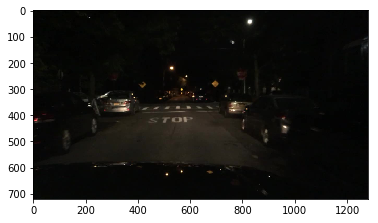

In [17]:
img=cv2.imread('/home/maharshi.t25/val/b5dd8a5f-431c4fc2.jpg')[:,:,::-1]
plt.imshow(img)
plt.show()

In [18]:
# Fetching the names of the image
fig_name=list()
for i,j in enumerate(det_val):
    fig_name.append(j)

In [19]:
s=np.linspace(0.0,1.0,1750)

# Morpholigical Dilation
kernel = np.ones((3,3),np.uint8)

for filename in fig_name:
    mask_img=np.zeros((720,1280), dtype=int)
    for i,j in enumerate(det_val[filename]):
        x=list() 
        y=list()
        for k,l in enumerate(det_val[filename][i]):
            x.append(det_val[filename][i][k][0])
            y.append(det_val[filename][i][k][1])
        xy=np.concatenate((np.asarray(x),np.asarray(y)), axis=0).reshape(2,len(x))
        curve1=bezier.Curve(xy, degree=4)
        points=curve1.evaluate_multi(s)
        
        try:
            mask_img[points[1,:].astype(int), points[0,:].astype(int)]=1
        except:
            mask_img[points[1,:].astype(int)-1, points[0,:].astype(int)-1]=1 
    mask_img = cv2.dilate(mask_img.astype('uint8'),kernel,iterations = 5)
    cv2.imwrite("/jet/prs/workspace/Maharshi_Assignment3/Maharshi_Data/Mask_data/"+filename+".png", mask_img)

In [20]:
jpg_val=glob.glob("/jet/prs/workspace/Maharshi_Assignment3/Maharshi_Data/Mask_data/*.png")
jpg_val

['/jet/prs/workspace/Maharshi_Assignment3/Maharshi_Data/Mask_data/c7eddd1b-73993ae6.jpg.png',
 '/jet/prs/workspace/Maharshi_Assignment3/Maharshi_Data/Mask_data/be0fdf82-972594ce.jpg.png',
 '/jet/prs/workspace/Maharshi_Assignment3/Maharshi_Data/Mask_data/c0905216-425f59d3.jpg.png',
 '/jet/prs/workspace/Maharshi_Assignment3/Maharshi_Data/Mask_data/bd956549-140a4edf.jpg.png',
 '/jet/prs/workspace/Maharshi_Assignment3/Maharshi_Data/Mask_data/be724abb-9a2a625c.jpg.png',
 '/jet/prs/workspace/Maharshi_Assignment3/Maharshi_Data/Mask_data/c7284932-f669eff5.jpg.png',
 '/jet/prs/workspace/Maharshi_Assignment3/Maharshi_Data/Mask_data/c4e96efa-ea5f524b.jpg.png',
 '/jet/prs/workspace/Maharshi_Assignment3/Maharshi_Data/Mask_data/c82cf5fc-e45643c4.jpg.png',
 '/jet/prs/workspace/Maharshi_Assignment3/Maharshi_Data/Mask_data/b214d1e1-f248c616.jpg.png',
 '/jet/prs/workspace/Maharshi_Assignment3/Maharshi_Data/Mask_data/c5c3116a-8bcf604c.jpg.png',
 '/jet/prs/workspace/Maharshi_Assignment3/Maharshi_Data/Mask

In [21]:
print('Number of raw images')
print(len(jpg_train))
print('Number of mask images')
print(len(jpg_val))

Number of raw images
10000
Number of mask images
10000


In [22]:
jpg_train

['/home/maharshi.t25/val/b5dd8a5f-431c4fc2.jpg',
 '/home/maharshi.t25/val/b6c2d715-ba5d6ecc.jpg',
 '/home/maharshi.t25/val/c9c9235f-8c053a4c.jpg',
 '/home/maharshi.t25/val/baa0bfdb-0267b9d2.jpg',
 '/home/maharshi.t25/val/c0c3d5f5-f17f878d.jpg',
 '/home/maharshi.t25/val/c0711468-991a6038.jpg',
 '/home/maharshi.t25/val/c51c4c12-e9006511.jpg',
 '/home/maharshi.t25/val/be2c1849-0713082f.jpg',
 '/home/maharshi.t25/val/b733b13d-e5dccc44.jpg',
 '/home/maharshi.t25/val/c013472b-6f3cec0b.jpg',
 '/home/maharshi.t25/val/c51ec845-67e41e84.jpg',
 '/home/maharshi.t25/val/b9baae14-474c5be2.jpg',
 '/home/maharshi.t25/val/ba64e51b-f88ab62e.jpg',
 '/home/maharshi.t25/val/b4475526-2f0bca11.jpg',
 '/home/maharshi.t25/val/be52b29f-de33251f.jpg',
 '/home/maharshi.t25/val/c8d0d179-7492f586.jpg',
 '/home/maharshi.t25/val/b26327fe-3ac19999.jpg',
 '/home/maharshi.t25/val/b2e54795-d8c2ba6d.jpg',
 '/home/maharshi.t25/val/b750dfba-288937b9.jpg',
 '/home/maharshi.t25/val/b39fe3cd-2a77c651.jpg',
 '/home/maharshi.t25

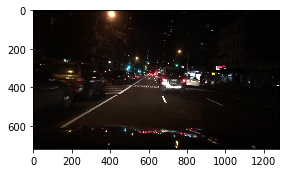

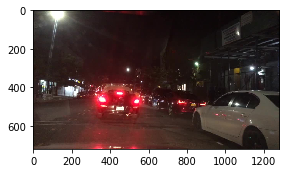

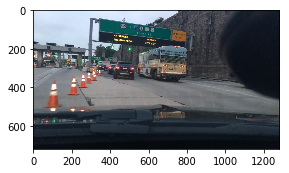

In [23]:
plt.figure(figsize=(15, 6))
plt.subplot(1,3,1)
img=cv2.imread(jpg_train[jpg_train.index('/home/maharshi.t25/val/'+jpg_val[0][64:-8]+'.jpg')])[:,:,::-1]
plt.imshow(img)
plt.show()

plt.figure(figsize=(15, 6))
plt.subplot(1,3,2)
img=cv2.imread(jpg_train[jpg_train.index('/home/maharshi.t25/val/'+jpg_val[120][64:-8]+'.jpg')])[:,:,::-1]
plt.imshow(img)
plt.show()

plt.figure(figsize=(15, 6))
plt.subplot(1,3,3)
img=cv2.imread(jpg_train[jpg_train.index('/home/maharshi.t25/val/'+jpg_val[9000][64:-8]+'.jpg')])[:,:,::-1]
plt.imshow(img)
plt.show()

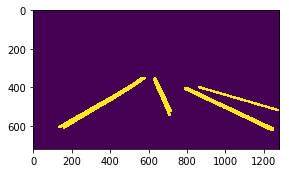

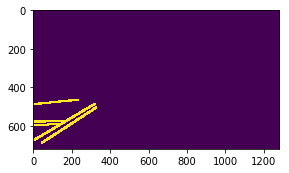

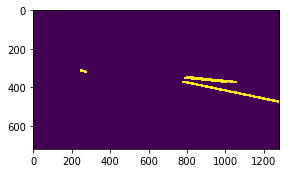

In [24]:
plt.figure(figsize=(15, 6))

plt.subplot(1,3,1)
img=cv2.imread(jpg_val[0])[:,:,0]
plt.imshow(img)
plt.show()

plt.figure(figsize=(15, 6))
plt.subplot(1,3,2)
img=cv2.imread(jpg_val[120])[:,:,0]
plt.imshow(img)
plt.show()

plt.figure(figsize=(15, 6))
plt.subplot(1,3,3)
img=cv2.imread(jpg_val[9000])[:,:,0]
plt.imshow(img)
plt.show()

In [25]:
np.unique(img)

array([0, 1], dtype=uint8)

In [26]:
#Proper arrangement of the list
jpg_train_updated=list()
for i,j in enumerate(jpg_val):
    jpg_train_updated.append(jpg_train[jpg_train.index('/home/maharshi.t25/val/'+j[64:-8]+'.jpg')])

In [27]:
jpg_train_updated[0]

'/home/maharshi.t25/val/c7eddd1b-73993ae6.jpg'

In [28]:
jpg_val[0]

'/jet/prs/workspace/Maharshi_Assignment3/Maharshi_Data/Mask_data/c7eddd1b-73993ae6.jpg.png'

In [29]:
#Checking whether the list is shuffled properly or not
"""
1 represents that they are same and 0 represents that they are different in order
"""
count=0
for i,j in enumerate(jpg_val):
    count=((j[64:-8]==jpg_train_updated[i][23:-4])*1)+count

if count == 10000:
    print("List sequence is properly arranged")
else:
    print("Please arranged it properly")

List sequence is properly arranged


In [30]:
#Splitting the data into Train, Validation and Test set
from sklearn.model_selection import train_test_split
raw_img_names=np.array(jpg_train_updated)
mask_img_names=np.array(jpg_val)
# Train split
raw_img_name_tr,raw_img_name_1,mask_img_name_tr,mask_img_name_1 = train_test_split(raw_img_names,mask_img_names,
                                                                                     shuffle=True,test_size=0.30)
# Validation - Test split
raw_img_name_val,raw_img_name_te,mask_img_name_val,mask_img_name_te = train_test_split(raw_img_name_1,mask_img_name_1,
                                                                                     shuffle=True,test_size=0.50)

In [31]:
# Dataset size after splitting
print('Number of raw images for training')
print(raw_img_name_tr.shape)
print('Number of mask images for training')
print(mask_img_name_tr.shape)

print('Number of raw images for validation')
print(raw_img_name_val.shape)
print('Number of mask images for validation')
print(mask_img_name_val.shape)

print('Number of raw images for testing')
print(raw_img_name_te.shape)
print('Number of mask images for testing')
print(mask_img_name_te.shape)

Number of raw images for training
(7000,)
Number of mask images for training
(7000,)
Number of raw images for validation
(1500,)
Number of mask images for validation
(1500,)
Number of raw images for testing
(1500,)
Number of mask images for testing
(1500,)


In [32]:
print(raw_img_name_tr[0])
print(mask_img_name_tr[0])

print(raw_img_name_val[0])
print(mask_img_name_val[0])

print(raw_img_name_te[0])
print(mask_img_name_te[0])

/home/maharshi.t25/val/c70f6d09-efd1a01f.jpg
/jet/prs/workspace/Maharshi_Assignment3/Maharshi_Data/Mask_data/c70f6d09-efd1a01f.jpg.png
/home/maharshi.t25/val/b7719f1d-e6e580dd.jpg
/jet/prs/workspace/Maharshi_Assignment3/Maharshi_Data/Mask_data/b7719f1d-e6e580dd.jpg.png
/home/maharshi.t25/val/b720f8cf-eb23da16.jpg
/jet/prs/workspace/Maharshi_Assignment3/Maharshi_Data/Mask_data/b720f8cf-eb23da16.jpg.png


In [33]:
pwd

'/jet/prs/workspace/Maharshi_Assignment3'

In [34]:
mask_img_name_tr[0][64:-8]

'c70f6d09-efd1a01f'

In [35]:
raw_img_name_tr[0][23:-4]

'c70f6d09-efd1a01f'

In [42]:
# Generating directories for Train, Validation and Test - Raw and Mask image data
if not os.path.exists('data'):
    os.makedirs('data')
    
if not os.path.exists('data/train'):
    os.makedirs('data/train')
    os.makedirs('data/train/raw')
    os.makedirs('data/train/mask')
    
if not os.path.exists('data/validation'):
    os.makedirs('data/validation')
    os.makedirs('data/validation/raw')
    os.makedirs('data/validation/mask')

if not os.path.exists('data/test'):
    os.makedirs('data/test')
    os.makedirs('data/test/raw')
    os.makedirs('data/test/mask')

# Reading training images and making a folder for the same the model
raw_img=0
mask_img=0

for i,j in enumerate(mask_img_name_tr):
    
    if j[64:-8] == raw_img_name_tr[i][23:-4]:
        
        raw_img=cv2.imread(raw_img_name_tr[i])[:,:,::-1]
        raw_img=cv2.resize(raw_img,dsize=(256,256),interpolation=cv2.INTER_NEAREST)
        
        mask_img=cv2.imread(j)[:,:,0]
        mask_img=cv2.resize(mask_img,dsize=(256,256),interpolation=cv2.INTER_NEAREST)
        
        cv2.imwrite('data/train/raw/'+j[64:-8]+'.png',raw_img)
        cv2.imwrite('data/train/mask/'+j[64:-8]+'.png',mask_img)
        
        raw_img=0
        mask_img=0

# Reading validation images and making a folder for the same the model
raw_img=0
mask_img=0

for i,j in enumerate(mask_img_name_val):
    
    if j[64:-8] == raw_img_name_val[i][23:-4]:
        
        raw_img=cv2.imread(raw_img_name_val[i])[:,:,::-1]
        raw_img=cv2.resize(raw_img,dsize=(256,256),interpolation=cv2.INTER_NEAREST)
        
        mask_img=cv2.imread(j)[:,:,0]
        mask_img=cv2.resize(mask_img,dsize=(256,256),interpolation=cv2.INTER_NEAREST)
        
        cv2.imwrite('data/validation/raw'+j[64:-8]+'.png',raw_img)
        cv2.imwrite('data/validation/mask'+j[64:-8]+'.png',mask_img)
        
        raw_img=0
        mask_img=0
        
# Reading testing images and making a folder for the same the model
raw_img=0
mask_img=0

for i,j in enumerate(mask_img_name_te):
    
    if j[64:-8] == raw_img_name_te[i][23:-4]:
        
        raw_img=cv2.imread(raw_img_name_te[i])[:,:,::-1]
        raw_img=cv2.resize(raw_img,dsize=(256,256),interpolation=cv2.INTER_NEAREST)
        
        mask_img=cv2.imread(j)[:,:,0]
        mask_img=cv2.resize(mask_img,dsize=(256,256),interpolation=cv2.INTER_NEAREST)
        
        cv2.imwrite('data/test/raw'+j[64:-8]+'.png',raw_img)
        cv2.imwrite('data/test/mask'+j[64:-8]+'.png',mask_img)
        
        raw_img=0
        mask_img=0

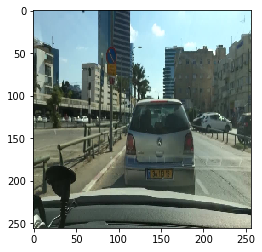

In [93]:
I=cv2.imread(glob.glob("data/train/raw/*.png")[500])
plt.imshow(I)

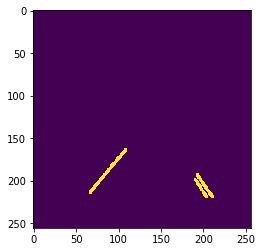

In [91]:
I=cv2.imread(glob.glob("data/train/mask/*.png")[500])[:,:,0]
plt.imshow(I)

In [84]:
images=np.full((len(glob.glob("data/train/raw/*.png")),256,256,3),0)
masks=np.full((len(glob.glob("data/train/mask/*.png")),256,256),0)

for i,j in enumerate(glob.glob("data/train/raw/*.png")):
    images[i,:,:,:]=cv2.imread(j)

for i,j in enumerate(glob.glob("data/train/mask/*.png")):
    masks[i,:,:]=cv2.imread(j)[:,:,0]

In [85]:
print(images.shape)
print(masks.shape)

(7000, 256, 256, 3)
(7000, 256, 256)


In [114]:
def custom_data_generator(image_path,mask_path,n_batches):
    
    img_batch=np.full((n_batches,256,256,3),0)
    mask_batch=np.full((n_batches,256,256,1),0)
    raw_files=np.array(os.listdir(image_path))
    
    while True:
        
        batch_paths=np.random.choice(raw_files,n_batches)
        
        for i,j in enumerate(batch_paths):
            img_batch[i,:,:,:]=cv2.imread(image_path+j)
            mask_batch[i,:,:,:]=cv2.imread(mask_path+j)[:,:,0]
        
    yield (img_batch,mask_batch)

In [116]:
custom_data_generator("data/train/raw/","data/train/mask/",5)

ValueError: could not broadcast input array from shape (256,256) into shape (256,256,1)

In [113]:
a=np.array(os.listdir("data/train/raw/"))
np.random.choice(a,5)

array(['c2021f20-6c78f954.png', 'ba54b6fd-8cf056a0.png',
       'c74a122c-1494f0b4.png', 'b8f63f02-014464f6.png',
       'bd9d3b75-c7800908.png'], dtype='<U21')

In [109]:
len(os.listdir("data/train/raw/"))

7000

In [38]:
import numpy as np
from keras.models import Sequential,Model
from keras.layers import Convolution2D, ZeroPadding2D, MaxPooling2D, Deconvolution2D, Cropping2D, Conv2DTranspose, UpSampling2D
from keras.layers import Input, Add, Dropout, Permute, add, concatenate, Reshape, Activation
from scipy.io import loadmat

from keras.preprocessing.image import ImageDataGenerator, load_img

/jet/var/python/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


# Visualization of labels for making the mask

In [380]:
# Another Image

Image_reading
[[503.674413, 373.137193], [357.797732, 374.672737]]
Points_extraction
[503.674413, 373.137193]
Points_extraction
[357.797732, 374.672737]
Image_reading
[[62.973282, 371.601649], [0, 368.53056]]
Points_extraction
[62.973282, 371.601649]
Points_extraction
[0, 368.53056]
Image_reading
[[1274.517503, 376.208281], [905.986941, 371.601649]]
Points_extraction
[1274.517503, 376.208281]
Points_extraction
[905.986941, 371.601649]


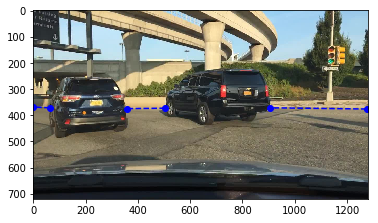

In [270]:
img = cv2.imread('0000f77c-6257be58.jpg')[:,:,::-1]
plt.imshow(img)

x=list()
y=list()
for i,j in enumerate(det_train['0000f77c-6257be58.jpg']):
    print('Image_reading')
    print(j)
    x=[]
    y=[]
    for k,l in enumerate(det_train['0000f77c-6257be58.jpg'][0]):
        print('Points_extraction')
        print(det_train['0000f77c-6257be58.jpg'][i][k])
        x.append(det_train['0000f77c-6257be58.jpg'][i][k][0])
        y.append(det_train['0000f77c-6257be58.jpg'][i][k][1])
    plt.plot(x, y, '--bo')

Image_reading
[[503.674413, 373.137193], [357.797732, 374.672737]]
l
[503.674413, 373.137193]
l
[357.797732, 374.672737]
Image_reading
[[62.973282, 371.601649], [0, 368.53056]]
l
[62.973282, 371.601649]
l
[0, 368.53056]
Image_reading
[[1274.517503, 376.208281], [905.986941, 371.601649]]
l
[1274.517503, 376.208281]
l
[905.986941, 371.601649]


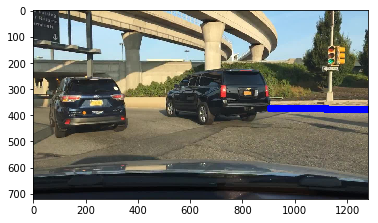

In [378]:
img = cv2.imread('0000f77c-6257be58.jpg')[:,:,::-1]
plt.imshow(img)
s=np.linspace(0.0,1.0,1750)
mask_img=np.zeros((img.shape[0],img.shape[1]), dtype=int)
x=list()
y=list()
for i,j in enumerate(det_train['0000f77c-6257be58.jpg']):
    print('Image_reading')
    print(j)
    x=[]
    y=[]
    for k,l in enumerate(det_train['0000f77c-6257be58.jpg'][0]):
        print('l')
        print(det_train['0000f77c-6257be58.jpg'][i][k])
        x.append(det_train['0000f77c-6257be58.jpg'][i][k][0])
        y.append(det_train['0000f77c-6257be58.jpg'][i][k][1])
    xy=np.concatenate((np.asarray(x),np.asarray(y)), axis=0).reshape(2,len(x))
    curve1=bezier.Curve(xy, degree=4)
    points=curve1.evaluate_multi(s)
        try:
        mask_img[points[1,:].astype(int), points[0,:].astype(int)]=1
    except:
        mask_img[points[1,:].astype(int)-1, points[0,:].astype(int)-1]=1
    
plot_values = plt.plot(points[0,:], points[1,:], '--bo')

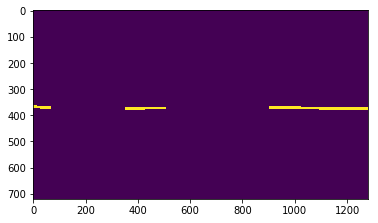

In [379]:
# Morpholigical Dilation
kernel = np.ones((3,3),np.uint8)
closing = cv2.dilate(mask_img.astype('uint8'),kernel,iterations = 5)
plt.imshow(closing)  

In [380]:
# Another Image

Image_reading
[[1046.865641, 499.101618], [1134.208426, 526.552206]]
Points_extraction
[1046.865641, 499.101618]
Points_extraction
[1134.208426, 526.552206]
Image_reading
[[1139.199441, 521.561191], [1049.361151, 494.110601]]
Points_extraction
[1139.199441, 521.561191]
Points_extraction
[1049.361151, 494.110601]
Image_reading
[[645.08884, 379.31723], [1280.195648, 539.029747]]
Points_extraction
[645.08884, 379.31723]
Points_extraction
[1280.195648, 539.029747]
Image_reading
[[1.247754, 653.823118], [178.428828, 560.241566], [485.376323, 393.042522], [501.597125, 363.096426]]
Points_extraction
[1.247754, 653.823118]
Points_extraction
[178.428828, 560.241566]


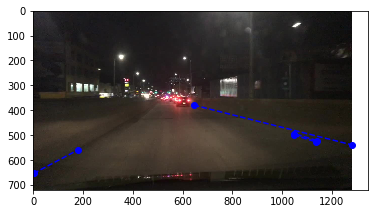

In [381]:
img = cv2.imread('0001542f-5ce3cf52.jpg')[:,:,::-1]
plt.imshow(img)

x=list()
y=list()
for i,j in enumerate(det_train['0001542f-5ce3cf52.jpg']):
    print('Image_reading')
    print(j)
    x=[]
    y=[]
    for k,l in enumerate(det_train['0001542f-5ce3cf52.jpg'][0]):
        print('Points_extraction')
        print(det_train['0001542f-5ce3cf52.jpg'][i][k])
        x.append(det_train['0001542f-5ce3cf52.jpg'][i][k][0])
        y.append(det_train['0001542f-5ce3cf52.jpg'][i][k][1])
    plt.plot(x, y, '--bo')

Image_reading
[[1046.865641, 499.101618], [1134.208426, 526.552206]]
l
[1046.865641, 499.101618]
l
[1134.208426, 526.552206]
Image_reading
[[1139.199441, 521.561191], [1049.361151, 494.110601]]
l
[1139.199441, 521.561191]
l
[1049.361151, 494.110601]
Image_reading
[[645.08884, 379.31723], [1280.195648, 539.029747]]
l
[645.08884, 379.31723]
l
[1280.195648, 539.029747]
Image_reading
[[1.247754, 653.823118], [178.428828, 560.241566], [485.376323, 393.042522], [501.597125, 363.096426]]
l
[1.247754, 653.823118]
l
[178.428828, 560.241566]


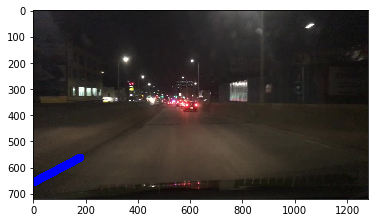

In [384]:
img = cv2.imread('0001542f-5ce3cf52.jpg')[:,:,::-1]
plt.imshow(img)
s=np.linspace(0.0,1.0,1750)
mask_img=np.zeros((img.shape[0],img.shape[1]), dtype=int)
x=list()
y=list()
for i,j in enumerate(det_train['0001542f-5ce3cf52.jpg']):
    print('Image_reading')
    print(j)
    x=[]
    y=[]
    for k,l in enumerate(det_train['0001542f-5ce3cf52.jpg'][0]):
        print('l')
        print(det_train['0001542f-5ce3cf52.jpg'][i][k])
        x.append(det_train['0001542f-5ce3cf52.jpg'][i][k][0])
        y.append(det_train['0001542f-5ce3cf52.jpg'][i][k][1])
    xy=np.concatenate((np.asarray(x),np.asarray(y)), axis=0).reshape(2,len(x))
    curve1=bezier.Curve(xy, degree=4)
    points=curve1.evaluate_multi(s)
    try:
        mask_img[points[1,:].astype(int), points[0,:].astype(int)]=1
    except:
        mask_img[points[1,:].astype(int)-1, points[0,:].astype(int)-1]=1
    
plot_values = plt.plot(points[0,:], points[1,:], '--bo')

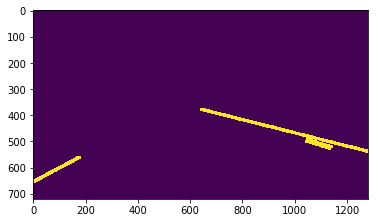

In [385]:
# Morpholigical Dilation
kernel = np.ones((3,3),np.uint8)
closing = cv2.dilate(mask_img.astype('uint8'),kernel,iterations = 5)
plt.imshow(closing)  

In [380]:
# Another Image

Image_reading
[[8.734278, 539.029746], [435.466161, 394.290278]]
Points_extraction
[8.734278, 539.029746]
Points_extraction
[435.466161, 394.290278]
Image_reading
[[403.024556, 572.719106], [474.146536, 509.083649], [552.755041, 429.227391], [625.124775, 366.839689]]
Points_extraction
[403.024556, 572.719106]
Points_extraction
[474.146536, 509.083649]
Image_reading
[[465.412258, 572.719106], [519.065682, 497.853863], [582.701138, 434.218407], [635.106808, 369.335197]]
Points_extraction
[465.412258, 572.719106]
Points_extraction
[519.065682, 497.853863]
Image_reading
[[1064.334198, 431.722899], [1105.510082, 444.200439, [[503.674413, 373.137193], [357.797732, 374.672737]], [[62.973282, 371.601649], [0, 368.53056]], [[1274.517503, 376.208281], [905.986941, 371.601649]]]]
Points_extraction
[1064.334198, 431.722899]
Points_extraction
[1105.510082, 444.200439, [[503.674413, 373.137193], [357.797732, 374.672737]], [[62.973282, 371.601649], [0, 368.53056]], [[1274.517503, 376.208281], [905.98

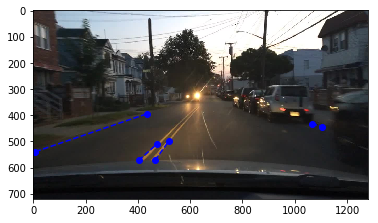

In [386]:
img = cv2.imread('0000f77c-cb820c98.jpg')[:,:,::-1]
plt.imshow(img)

x=list()
y=list()
for i,j in enumerate(det_train['0000f77c-cb820c98.jpg']):
    print('Image_reading')
    print(j)
    x=[]
    y=[]
    for k,l in enumerate(det_train['0000f77c-cb820c98.jpg'][0]):
        print('Points_extraction')
        print(det_train['0000f77c-cb820c98.jpg'][i][k])
        x.append(det_train['0000f77c-cb820c98.jpg'][i][k][0])
        y.append(det_train['0000f77c-cb820c98.jpg'][i][k][1])
    plt.plot(x, y, '--bo')

Image_reading
[[8.734278, 539.029746], [435.466161, 394.290278]]
l
[8.734278, 539.029746]
l
[435.466161, 394.290278]
Image_reading
[[403.024556, 572.719106], [474.146536, 509.083649], [552.755041, 429.227391], [625.124775, 366.839689]]
l
[403.024556, 572.719106]
l
[474.146536, 509.083649]
Image_reading
[[465.412258, 572.719106], [519.065682, 497.853863], [582.701138, 434.218407], [635.106808, 369.335197]]
l
[465.412258, 572.719106]
l
[519.065682, 497.853863]
Image_reading
[[1064.334198, 431.722899], [1105.510082, 444.200439, [[503.674413, 373.137193], [357.797732, 374.672737]], [[62.973282, 371.601649], [0, 368.53056]], [[1274.517503, 376.208281], [905.986941, 371.601649]]]]
l
[1064.334198, 431.722899]
l
[1105.510082, 444.200439, [[503.674413, 373.137193], [357.797732, 374.672737]], [[62.973282, 371.601649], [0, 368.53056]], [[1274.517503, 376.208281], [905.986941, 371.601649]]]


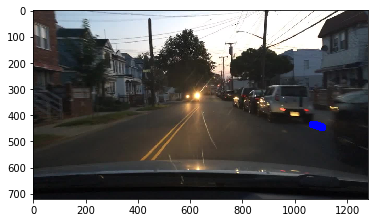

In [387]:
img = cv2.imread('0000f77c-cb820c98.jpg')[:,:,::-1]
plt.imshow(img)
s=np.linspace(0.0,1.0,1750)
mask_img=np.zeros((img.shape[0],img.shape[1]), dtype=int)
x=list()
y=list()
for i,j in enumerate(det_train['0000f77c-cb820c98.jpg']):
    print('Image_reading')
    print(j)
    x=[]
    y=[]
    for k,l in enumerate(det_train['0000f77c-cb820c98.jpg'][0]):
        print('l')
        print(det_train['0000f77c-cb820c98.jpg'][i][k])
        x.append(det_train['0000f77c-cb820c98.jpg'][i][k][0])
        y.append(det_train['0000f77c-cb820c98.jpg'][i][k][1])
    xy=np.concatenate((np.asarray(x),np.asarray(y)), axis=0).reshape(2,len(x))
    curve1=bezier.Curve(xy, degree=4)
    points=curve1.evaluate_multi(s)
    try:
        mask_img[points[1,:].astype(int), points[0,:].astype(int)]=1
    except:
        mask_img[points[1,:].astype(int)-1, points[0,:].astype(int)-1]=1
    
plot_values = plt.plot(points[0,:], points[1,:], '--bo')

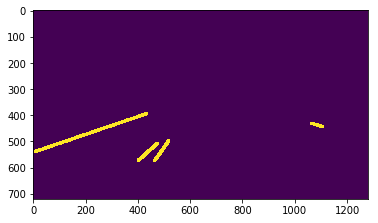

In [388]:
# Morpholigical Dilation
kernel = np.ones((3,3),np.uint8)
closing = cv2.dilate(mask_img.astype('uint8'),kernel,iterations = 5)
plt.imshow(closing)  